# ID3 Decision Tree Classifier for Iris Dataset

This notebook implements the ID3 (Iterative Dichotomiser 3) algorithm from scratch to classify iris flowers based on their features.

## Algorithm Overview:
- Uses **Information Gain** to select the best splitting attribute
- Builds a decision tree by recursively splitting on the most informative features
- Handles categorical data naturally

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from collections import Counter
import math

In [2]:
# Load and prepare the iris dataset
def load_iris_data():
    """Load and return iris dataset as pandas DataFrame"""
    iris = load_iris()
    
    # Create DataFrame
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['species'] = iris.target_names[iris.target]
    
    return df

# Load the data
iris_df = load_iris_data()
print("Iris Dataset Shape:", iris_df.shape)
print("\nFirst 5 rows:")
print(iris_df.head())
print("\nTarget distribution:")
print(iris_df['species'].value_counts())

Iris Dataset Shape: (150, 5)

First 5 rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  

Target distribution:
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


In [3]:
# Convert continuous features to categorical for ID3 algorithm
def discretize_features(df, n_bins=3):
    """Convert continuous features to categorical bins"""
    df_discrete = df.copy()
    
    # Discretize numerical features
    feature_cols = ['sepal length (cm)', 'sepal width (cm)', 
                   'petal length (cm)', 'petal width (cm)']
    
    for col in feature_cols:
        # Create bins with labels
        df_discrete[col] = pd.cut(df[col], bins=n_bins, 
                                 labels=['Low', 'Medium', 'High'])
    
    return df_discrete

# Discretize the features
iris_discrete = discretize_features(iris_df)
print("Discretized Dataset:")
print(iris_discrete.head())
print("\nFeature value counts:")
for col in iris_discrete.columns[:-1]:
    print(f"\n{col}:")
    print(iris_discrete[col].value_counts())

Discretized Dataset:
  sepal length (cm) sepal width (cm) petal length (cm) petal width (cm)  \
0               Low           Medium               Low              Low   
1               Low           Medium               Low              Low   
2               Low           Medium               Low              Low   
3               Low           Medium               Low              Low   
4               Low           Medium               Low              Low   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  

Feature value counts:

sepal length (cm):
sepal length (cm)
Medium    71
Low       59
High      20
Name: count, dtype: int64

sepal width (cm):
sepal width (cm)
Medium    88
Low       47
High      15
Name: count, dtype: int64

petal length (cm):
petal length (cm)
Medium    54
Low       50
High      46
Name: count, dtype: int64

petal width (cm):
petal width (cm)
Medium    54
Low       50
High      46
Name: count, dtype: int64


In [4]:
# ID3 Decision Tree Implementation
class ID3DecisionTree:
    """Simple ID3 Decision Tree implementation"""
    
    def __init__(self):
        self.tree = None
        self.feature_names = None
    
    def entropy(self, labels):
        """Calculate entropy of a set of labels"""
        if len(labels) == 0:
            return 0
        
        # Count occurrences of each label
        counts = Counter(labels)
        total = len(labels)
        
        # Calculate entropy
        entropy = 0
        for count in counts.values():
            if count > 0:
                p = count / total
                entropy -= p * math.log2(p)
        
        return entropy
    
    def information_gain(self, data, target_col, feature_col):
        """Calculate information gain for a feature"""
        # Calculate initial entropy
        initial_entropy = self.entropy(data[target_col])
        
        # Calculate weighted entropy after split
        feature_values = data[feature_col].unique()
        weighted_entropy = 0
        total_samples = len(data)
        
        for value in feature_values:
            subset = data[data[feature_col] == value]
            weight = len(subset) / total_samples
            weighted_entropy += weight * self.entropy(subset[target_col])
        
        # Information gain = Initial entropy - Weighted entropy
        return initial_entropy - weighted_entropy
    
    def find_best_feature(self, data, target_col, features):
        """Find the feature with highest information gain"""
        best_gain = -1
        best_feature = None
        
        for feature in features:
            gain = self.information_gain(data, target_col, feature)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
        
        return best_feature, best_gain
    
    def build_tree(self, data, target_col, features):
        """Recursively build the decision tree"""
        # Base cases
        target_values = data[target_col].unique()
        
        # If all samples have same class, return leaf node
        if len(target_values) == 1:
            return target_values[0]
        
        # If no features left, return most common class
        if len(features) == 0:
            return data[target_col].mode()[0]
        
        # Find best feature to split on
        best_feature, best_gain = self.find_best_feature(data, target_col, features)
        
        # If no information gain, return most common class
        if best_gain == 0:
            return data[target_col].mode()[0]
        
        # Create tree node
        tree = {best_feature: {}}
        
        # Remove best feature from remaining features
        remaining_features = [f for f in features if f != best_feature]
        
        # Create branches for each value of the best feature
        for value in data[best_feature].unique():
            subset = data[data[best_feature] == value]
            
            if len(subset) == 0:
                # If subset is empty, use most common class from parent
                tree[best_feature][value] = data[target_col].mode()[0]
            else:
                # Recursively build subtree
                tree[best_feature][value] = self.build_tree(subset, target_col, remaining_features)
        
        return tree
    
    def fit(self, data, target_col):
        """Train the decision tree"""
        features = [col for col in data.columns if col != target_col]
        self.feature_names = features
        self.tree = self.build_tree(data, target_col, features)
        return self
    
    def predict_single(self, sample, tree=None):
        """Predict class for a single sample"""
        if tree is None:
            tree = self.tree
        
        # If tree is a leaf node (string), return the class
        if isinstance(tree, str):
            return tree
        
        # Get the feature to split on
        feature = list(tree.keys())[0]
        feature_value = sample[feature]
        
        # Navigate to the appropriate subtree
        if feature_value in tree[feature]:
            return self.predict_single(sample, tree[feature][feature_value])
        else:
            # If feature value not seen in training, return most common class
            # For simplicity, return the first available class
            first_subtree = list(tree[feature].values())[0]
            if isinstance(first_subtree, str):
                return first_subtree
            else:
                return self.predict_single(sample, first_subtree)
    
    def predict(self, data):
        """Predict classes for multiple samples"""
        predictions = []
        for _, sample in data.iterrows():
            pred = self.predict_single(sample)
            predictions.append(pred)
        return predictions
    
    def print_tree(self, tree=None, indent=""):
        """Print the decision tree structure"""
        if tree is None:
            tree = self.tree
        
        if isinstance(tree, str):
            print(f"{indent}-> {tree}")
            return
        
        for feature, branches in tree.items():
            print(f"{indent}{feature}:")
            for value, subtree in branches.items():
                print(f"{indent}  {value}:")
                self.print_tree(subtree, indent + "    ")

print("ID3 Decision Tree class implemented successfully!")

ID3 Decision Tree class implemented successfully!


In [5]:
# Split data into training and testing sets
X = iris_discrete.drop('species', axis=1)
y = iris_discrete['species']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set target distribution:")
print(y_train.value_counts())
print(f"\nTest set target distribution:")
print(y_test.value_counts())

Training set shape: (105, 4)
Test set shape: (45, 4)

Training set target distribution:
species
versicolor    35
setosa        35
virginica     35
Name: count, dtype: int64

Test set target distribution:
species
virginica     15
versicolor    15
setosa        15
Name: count, dtype: int64


In [6]:
# Train the ID3 Decision Tree
print("Training ID3 Decision Tree...")

# Combine features and target for training
train_data = X_train.copy()
train_data['species'] = y_train

# Create and train the model
id3_tree = ID3DecisionTree()
id3_tree.fit(train_data, 'species')

print("Training completed!")
print("\n" + "="*50)
print("DECISION TREE STRUCTURE:")
print("="*50)
id3_tree.print_tree()

Training ID3 Decision Tree...
Training completed!

DECISION TREE STRUCTURE:
petal width (cm):
  Medium:
    petal length (cm):
      Medium:
        -> versicolor
      High:
        sepal length (cm):
          Medium:
            -> versicolor
          High:
            -> virginica
  Low:
    -> setosa
  High:
    petal length (cm):
      High:
        -> virginica
      Medium:
        sepal width (cm):
          Medium:
            -> versicolor
          Low:
            -> virginica


In [7]:
# Make predictions on test set
print("Making predictions on test set...")

# Make predictions
y_pred = id3_tree.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\n" + "="*50)
print("CLASSIFICATION REPORT:")
print("="*50)
print(classification_report(y_test, y_pred))

# Show some example predictions
print("\n" + "="*50)
print("SAMPLE PREDICTIONS:")
print("="*50)
for i in range(min(10, len(X_test))):
    sample = X_test.iloc[i]
    actual = y_test.iloc[i]
    predicted = y_pred[i]
    
    print(f"Sample {i+1}:")
    print(f"  Features: {dict(sample)}")
    print(f"  Actual: {actual}, Predicted: {predicted}")
    print(f"  {'✓ Correct' if actual == predicted else '✗ Wrong'}")
    print()

Making predictions on test set...

Test Accuracy: 0.8889

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.75      1.00      0.86        15
   virginica       1.00      0.67      0.80        15

    accuracy                           0.89        45
   macro avg       0.92      0.89      0.89        45
weighted avg       0.92      0.89      0.89        45


SAMPLE PREDICTIONS:
Sample 1:
  Features: {'sepal length (cm)': 'High', 'sepal width (cm)': 'Medium', 'petal length (cm)': 'High', 'petal width (cm)': 'High'}
  Actual: virginica, Predicted: virginica
  ✓ Correct

Sample 2:
  Features: {'sepal length (cm)': 'Medium', 'sepal width (cm)': 'Medium', 'petal length (cm)': 'Medium', 'petal width (cm)': 'Medium'}
  Actual: versicolor, Predicted: versicolor
  ✓ Correct

Sample 3:
  Features: {'sepal length (cm)': 'Medium', 'sepal width (cm)': 'Low', 'petal length (cm)': 'High', 'petal widt

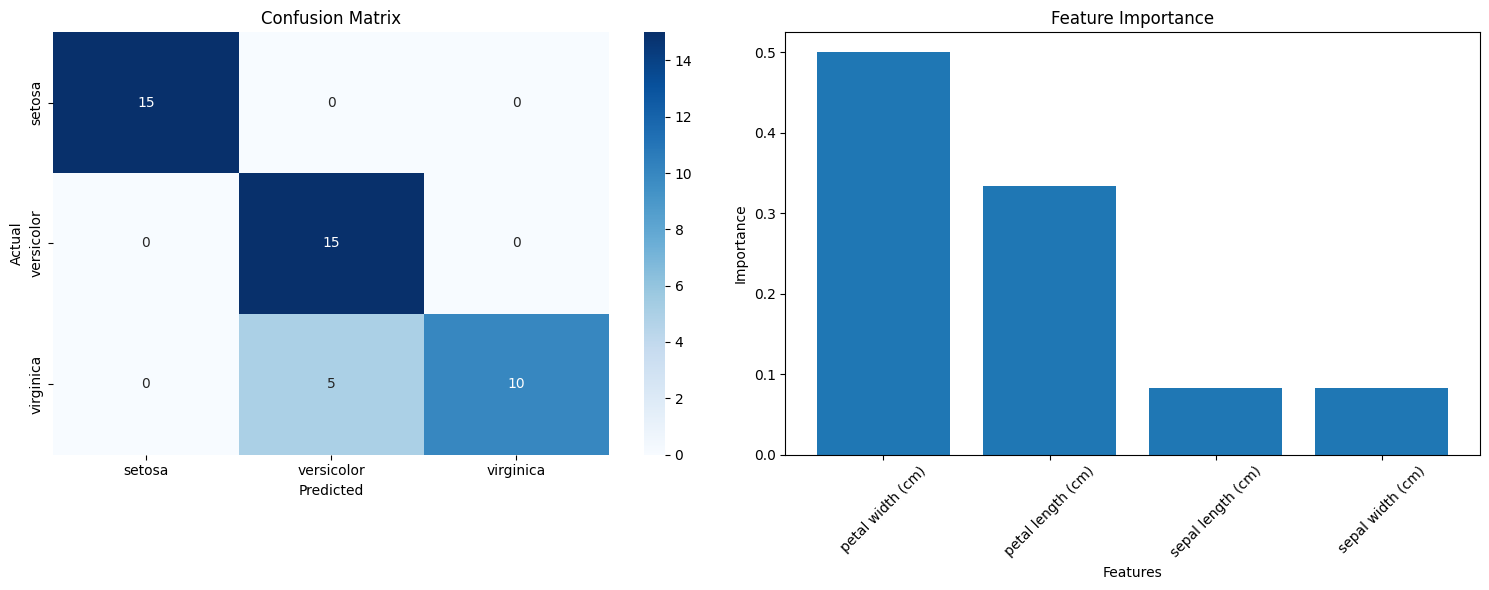


Final Results Summary:
Algorithm: ID3 Decision Tree
Dataset: Iris (discretized)
Test Accuracy: 0.8889
Total samples: 150
Training samples: 105
Test samples: 45
Features used: 4
Classes: 3
✓ Implementation completed successfully!


In [8]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test),
            ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Feature importance (based on tree structure)
def calculate_feature_importance(tree, total_samples=len(train_data)):
    """Calculate simple feature importance based on tree usage"""
    importance = {}
    
    def traverse_tree(node, samples):
        if isinstance(node, str):
            return
        
        for feature, branches in node.items():
            if feature not in importance:
                importance[feature] = 0
            importance[feature] += samples
            
            for value, subtree in branches.items():
                # Assume equal distribution for simplicity
                branch_samples = samples / len(branches)
                traverse_tree(subtree, branch_samples)
    
    traverse_tree(tree, total_samples)
    
    # Normalize
    total = sum(importance.values()) if importance else 1
    for feature in importance:
        importance[feature] /= total
    
    return importance

feature_importance = calculate_feature_importance(id3_tree.tree)

# Plot feature importance
if feature_importance:
    features = list(feature_importance.keys())
    importance_values = list(feature_importance.values())
    
    axes[1].bar(features, importance_values)
    axes[1].set_title('Feature Importance')
    axes[1].set_xlabel('Features')
    axes[1].set_ylabel('Importance')
    axes[1].tick_params(axis='x', rotation=45)
else:
    axes[1].text(0.5, 0.5, 'No feature importance\ncalculated', 
                ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Feature Importance')

plt.tight_layout()
plt.show()

print(f"\nFinal Results Summary:")
print(f"{'='*30}")
print(f"Algorithm: ID3 Decision Tree")
print(f"Dataset: Iris (discretized)")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Total samples: {len(iris_df)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features used: {len(X.columns)}")
print(f"Classes: {len(np.unique(y))}")
print("✓ Implementation completed successfully!")